<a href="https://colab.research.google.com/github/Shrieejanani/Covid_19-prediction/blob/main/Covid_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Libraries**

In [ ]:
 pip install chart_studio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 2.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import chart_studio.plotly as py
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode (connected=True)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
import warnings
warnings.filterwarnings('ignore')

**Loading the Dataset**

In [ ]:
df = pd.read_csv("/content/Covid-19_Dataset.csv")

In [ ]:
df.head(2)

,id,case_in_country,reporting date,summary,location,country,gender,age,symptom_onset,If_onset_approximated,hosp_visit_date,exposure_start,exposure_end,visiting Wuhan,from Wuhan,death,recovered,symptom,source,link
0,765,15.0,02-10-20,new confirmed COVID-19 patient in Vietnam: 3 m...,Vinh Phuc,Vietnam,NaN,0.25,NaN,NaN,NaN,NaN,NaN,0,0,0,1,NaN,Vietnam News,https://vietnamnews.vn/society/591803/viet-nam...
1,477,27.0,02-05-20,new confirmed COVID-19 patient in Singapore: m...,Singapore,Singapore,male,0.50,NaN,NaN,NaN,1/23/2020,02-03-20,0,0,0,1,NaN,Straits Times,https://www.straitstimes.com/singapore/health/...


In [ ]:
df.shape

(1085, 20)

In [ ]:
df.dtypes

id                         int64
case_in_country          float64
reporting date            object
summary                   object
location                  object
country                   object
gender                    object
age                      float64
symptom_onset             object
If_onset_approximated    float64
hosp_visit_date           object
exposure_start            object
exposure_end              object
visiting Wuhan             int64
from Wuhan                 int64
death                      int64
recovered                  int64
symptom                   object
source                    object
link                      object
dtype: object

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1085 entries, 0 to 1084
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1085 non-null   int64  
 1   case_in_country        888 non-null    float64
 2   reporting date         1084 non-null   object 
 3   summary                1080 non-null   object 
 4   location               1085 non-null   object 
 5   country                1085 non-null   object 
 6   gender                 902 non-null    object 
 7   age                    843 non-null    float64
 8   symptom_onset          563 non-null    object 
 9   If_onset_approximated  560 non-null    float64
 10  hosp_visit_date        507 non-null    object 
 11  exposure_start         128 non-null    object 
 12  exposure_end           341 non-null    object 
 13  visiting Wuhan         1085 non-null   int64  
 14  from Wuhan             1085 non-null   int64  
 15  deat

**Data Cleaning**

First we remove the unnecessary columns

In [ ]:
df.drop(['id','case_in_country','summary','symptom_onset','If_onset_approximated',
'hosp_visit_date','exposure_start','exposure_end','symptom','source','link'],axis=1,inplace=True)

In [ ]:
df.isnull().sum()

reporting date      1
location            0
country             0
gender            183
age               242
visiting Wuhan      0
from Wuhan          0
death               0
recovered           0
dtype: int64

In [ ]:
100*df.isnull().sum()/df.shape[0]

reporting date     0.092166
location           0.000000
country            0.000000
gender            16.866359
age               22.304147
visiting Wuhan     0.000000
from Wuhan         0.000000
death              0.000000
recovered          0.000000
dtype: float64

In [ ]:
df["age"] = df["age"].fillna(df['age'].mean())

In [ ]:
df_dum = pd.get_dummies(df["gender"].dropna(),drop_first=True)

In [ ]:
df_dum["male"].median()

1.0

so we fill the null values in gender column with "male"

In [ ]:
df["gender"]=df['gender'].fillna("male")

Finally the column that contain less than 0.5% null values are remained,and we drop the rows of df that contains these null values

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.isnull().sum()

reporting date    0
location          0
country           0
gender            0
age               0
visiting Wuhan    0
from Wuhan        0
death             0
recovered         0
dtype: int64

**Feature Engineering**

we rename some of the columns

In [ ]:
df.columns=df.columns.str.lower().str.replace(' ','_')

Now we change the format of date and add a new month column to df

In [ ]:
df['reporting_date'] = pd.to_datetime(df['reporting_date'])

In [ ]:
df["year"] = df['reporting_date'].apply(lambda x:x.year)
df['month'] = df['reporting_date'].apply(lambda x:x.month)

In [ ]:
df["month"].unique()

array([2, 1])

As there is only one year,we can remove the year column

In [ ]:
df.head(1)

,reporting_date,location,country,gender,age,visiting_wuhan,from_wuhan,death,recovered,year,month
0,2020-02-10,Vinh Phuc,Vietnam,male,0.25,0,0,0,1,2020,2


In [ ]:
df.drop(['reporting_date','year'],axis=1,inplace=True)

In [ ]:
df.head(2)

,location,country,gender,age,visiting_wuhan,from_wuhan,death,recovered,month
0,Vinh Phuc,Vietnam,male,0.25,0,0,0,1,2
1,Singapore,Singapore,male,0.50,0,0,0,1,2


**Exploratory Data analysis**

We want to find the number of patients died and recovered based on their age

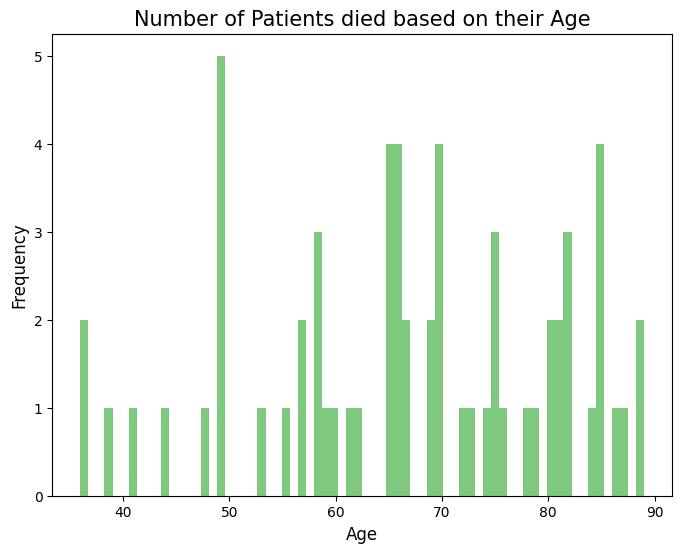

In [ ]:
plt.figure(figsize=(8,6))
df[df['death']==1]['age'].plot(kind='hist',bins=70,colormap='Accent')
plt.title("Number of Patients died based on their Age",fontsize=15)
plt.xlabel('Age',fontsize=12)
plt.ylabel("Frequency",fontsize=12)
plt.show()

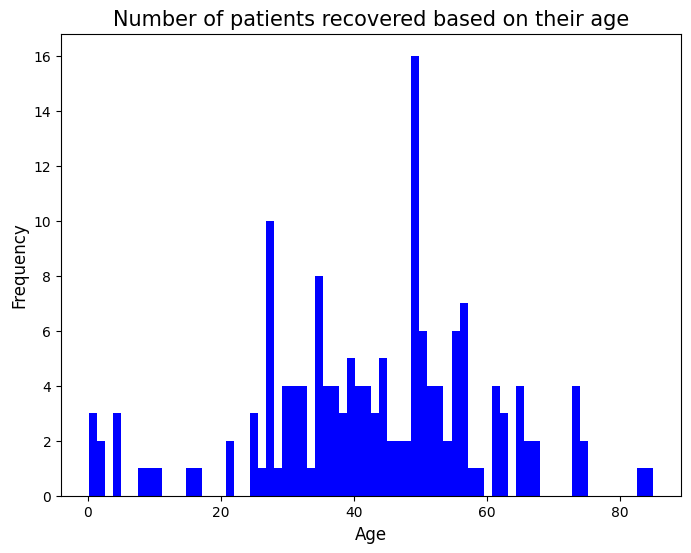

In [ ]:
plt.figure(figsize=(8,6))
df[df['recovered']==1]['age'].plot(kind='hist',bins=70,colormap='winter')
plt.title('Number of patients recovered based on their age',fontsize=15)
plt.xlabel("Age",fontsize=12)
plt.ylabel("Frequency",fontsize=12)
plt.show()

In [ ]:
print("Current count of Patients:",df["death"].count())
print("Number of Dead Patients:",df[df['death']==1]["death"].count())
print("Number of Recovered Patients:",df[df["recovered"]==1]['death'].count())
print("Number of Patients Receiving treatment:",df[(df["death"]==0)&(df['recovered']==0)]["death"].count())

Current count of Patients: 1084
Number of Dead Patients: 63
Number of Recovered Patients: 159
Number of Patients Receiving treatment: 862


Text(0, 0.5, 'Number')

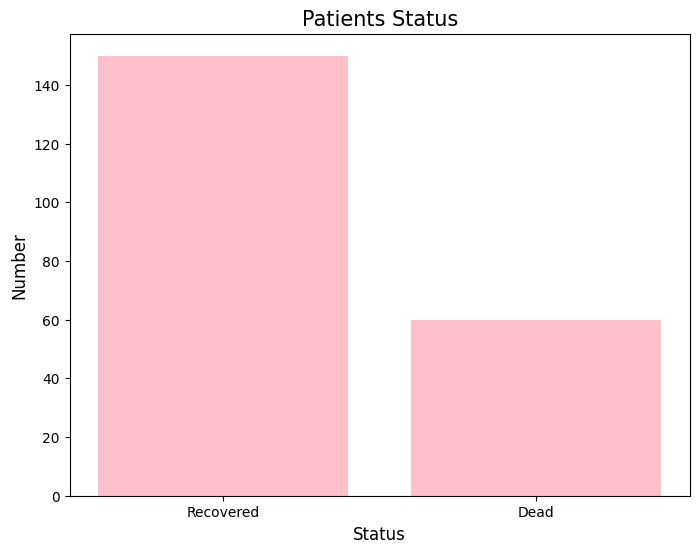

In [ ]:
plt.figure(figsize=(8,6))
plt.bar(x=['Recovered','Dead'],height=(150,60),color='pink')
plt.title("Patients Status",fontsize=15)
plt.xlabel("Status",fontsize=12)
plt.ylabel("Number",fontsize=12)

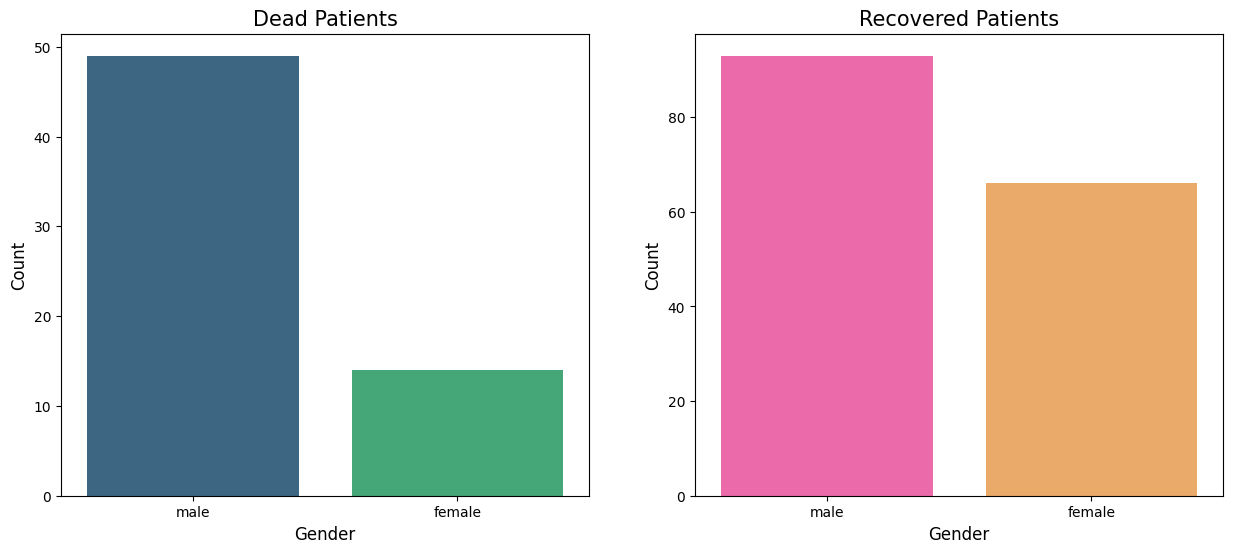

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.countplot(x='gender',data=df[df["death"]==1],palette='viridis')
plt.xlabel("Gender",fontsize=12)
plt.ylabel('Count',fontsize=12)
plt.title("Dead Patients",fontsize=15)
plt.subplot(1,2,2)
sns.countplot(x='gender',data=df[df['recovered']==1],palette='spring')
plt.xlabel("Gender",fontsize=12)
plt.ylabel('Count',fontsize=12)
plt.title("Recovered Patients",fontsize=15)
plt.show()

Text(0.5, 1.0, 'Recovered Patients')

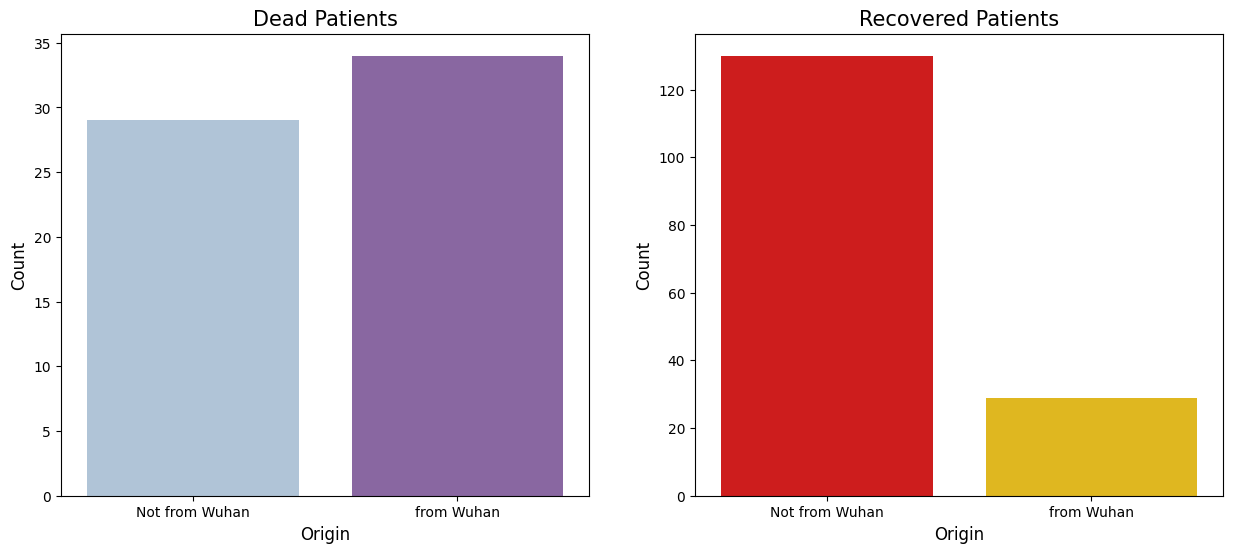

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.countplot(x='from_wuhan',data=df[df['death']==1],palette='BuPu')
plt.xticks([0,1],['Not from Wuhan','from Wuhan'])
plt.xlabel("Origin",fontsize=12)
plt.ylabel("Count",fontsize=12)
plt.title("Dead Patients",fontsize=15)
plt.subplot(1,2,2)
sns.countplot(x='from_wuhan',data=df[df['recovered']==1],palette='hot')
plt.xticks([0,1],['Not from Wuhan','from Wuhan'])
plt.xlabel("Origin",fontsize=12)
plt.ylabel("Count",fontsize=12)
plt.title("Recovered Patients",fontsize=15)


In [ ]:
country_order=list(df.groupby("country").count()['location'].sort_values(ascending=False).index)

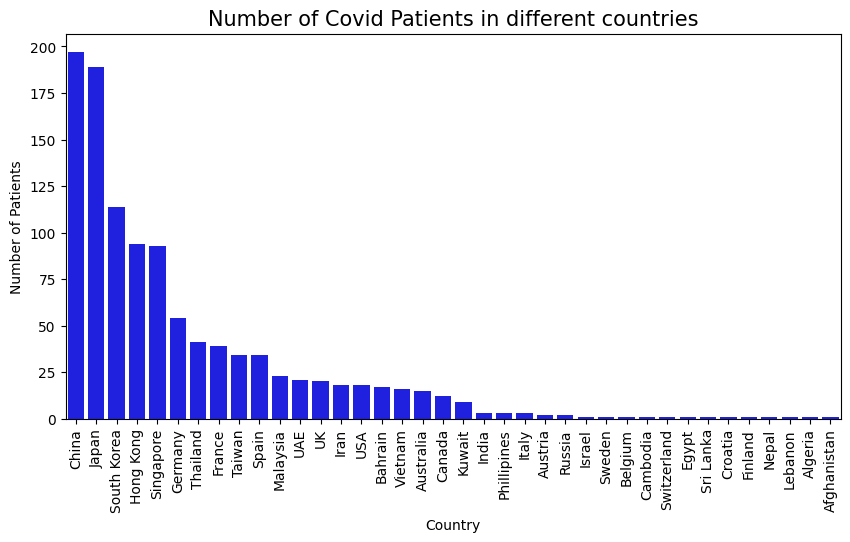

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x='country',data=df,color='blue',order=country_order)
plt.xticks(rotation=90)
plt.xlabel("Country")
plt.ylabel("Number of Patients")
plt.title("Number of Covid Patients in different countries",fontsize=15)
plt.show()

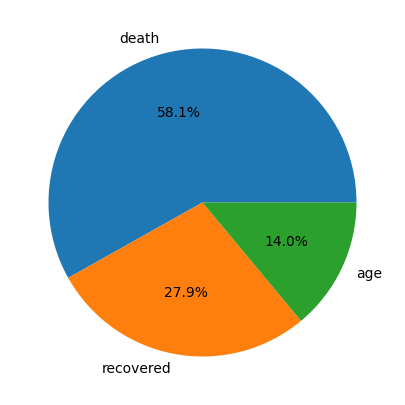

In [ ]:
labels = ['death','recovered','age']
values =[500,240,120]

f,ax =plt.subplots(figsize=(10,5))
plt.pie(values,labels=labels,autopct='%1.1f%%')
plt.show()

In [ ]:
groupby_df = df.groupby('country').sum()

**Prediction of Death or Recovery of Patients**

***Label Encoding***

Location

In [ ]:
le1=LabelEncoder()
le1.fit(df["location"])
df['location']=le1.transform(df['location'])

Country

In [ ]:
le2 = LabelEncoder()
le2.fit(df['country'])
df['country']=le2.transform(df["country"])

Gender

In [ ]:
le3 = LabelEncoder()
le3.fit(df['gender'])
df['gender']=le3.transform(df['gender'])

In [ ]:
df.head()

,location,country,gender,age,visiting_wuhan,from_wuhan,death,recovered,month
0,141,37,1,0.25,0,0,0,1,2
1,118,26,1,0.50,0,0,0,1,2
2,118,26,1,1.00,0,0,0,1,2
3,42,8,0,2.00,1,0,0,0,1
4,60,22,1,2.00,0,0,0,1,1


**Predicting the Recovery**

Splitting the data

In [ ]:
y = df['recovered']
X = df[['location','country','gender','age','visiting_wuhan','from_wuhan','month']]

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

Random Forest Classifier

In [ ]:
rfc1 = RandomForestClassifier(n_estimators=200)
rfc1.fit(X_train,y_train)
prediction_rfc1 = rfc1.predict(X_test)

In [ ]:
print(confusion_matrix(y_test,prediction_rfc1))
print("\n")
print(classification_report(y_test,prediction_rfc1))

[[178   7]
 [ 13  19]]


              precision    recall  f1-score   support

           0       0.93      0.96      0.95       185
           1       0.73      0.59      0.66        32

    accuracy                           0.91       217
   macro avg       0.83      0.78      0.80       217
weighted avg       0.90      0.91      0.90       217



In [ ]:
rf_recovery_acc = accuracy_score(y_test,prediction_rfc1)
rf_recovery_acc

0.9078341013824884

**Support Vector Classifier**

In [61]:
svc2 = SVC()
svc2.fit(X_train,y_train)
predictions_svc2 = svc2.predict(X_test)

In [62]:
print(confusion_matrix(y_test,predictions_svc2))
print('\n')
print(classification_report(y_test,predictions_svc2))

[[185   0]
 [ 32   0]]


              precision    recall  f1-score   support

           0       0.85      1.00      0.92       185
           1       0.00      0.00      0.00        32

    accuracy                           0.85       217
   macro avg       0.43      0.50      0.46       217
weighted avg       0.73      0.85      0.78       217



To improve the result obtained by SVC,we define C and gamma Paramaters

In [63]:
param_grid={'C':[0.1,1,10,100,1000], 'gamma':[1,0.1,0.01,0.001], 'kernel':['rbf']}

In [64]:
gs2=GridSearchCV(SVC(),param_grid, verbose=3)
gs2.fit(X_train,y_train)
predictions_gs2=gs2.predict(X_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.851 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.851 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.855 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.855 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.855 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.851 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.851 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.855 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.855 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.855 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.851 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

In [65]:
print(confusion_matrix(y_test,predictions_gs2))
print('\n')
print(classification_report(y_test,predictions_gs2))

[[182   3]
 [ 26   6]]


              precision    recall  f1-score   support

           0       0.88      0.98      0.93       185
           1       0.67      0.19      0.29        32

    accuracy                           0.87       217
   macro avg       0.77      0.59      0.61       217
weighted avg       0.84      0.87      0.83       217



In [66]:
svr_death_acc = accuracy_score(y_test,predictions_gs2)
svr_death_acc

0.8663594470046083

**XGBoost Classifier**

In [67]:
xgbc2=xgb.XGBClassifier(n_estimators=200, learning_rate=0.08, gamma=0, subsample=0.5,colsample_bytree=1, max_depth=8)
xgbc2.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.08, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [68]:
predictions_xgbc2=xgbc2.predict(X_test)

In [69]:
print(confusion_matrix(y_test,predictions_xgbc2))
print('\n')
print(classification_report(y_test,predictions_xgbc2))

[[178   7]
 [ 11  21]]


              precision    recall  f1-score   support

           0       0.94      0.96      0.95       185
           1       0.75      0.66      0.70        32

    accuracy                           0.92       217
   macro avg       0.85      0.81      0.83       217
weighted avg       0.91      0.92      0.91       217



In [70]:
xg_death_acc = accuracy_score(y_test,predictions_xgbc2)
xg_death_acc

0.9170506912442397

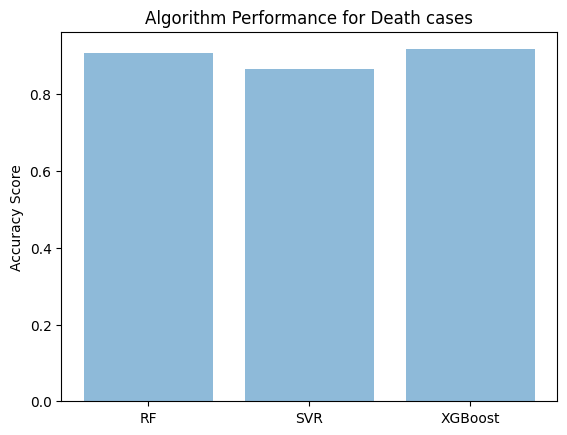

In [72]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = ('RF','SVR','XGBoost')
y_pos = np.arange(len(objects))
performance = [rf_recovery_acc,svr_death_acc,xg_death_acc]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy Score')
plt.title('Algorithm Performance for Death cases')

plt.show()